## Connectivity

While connectivity -- or the correlation of timeseries data across brain regions -- has been studied in EEG data for two decades, it has recently surged in popularity. Inspired by work in the fMRI domain which showed that the brain is comprised of multi-region networks, scientists have recently asked whether they can find correlations in EEG activity across electrodes and brain regions. We say that regions with significant correlation exhibit **connectivity**, and may be using electrophysiological mechanisms to communicate or coordinate information processing.

<center>
<img src="figures/brain_network.png" width=600>
</center>

Obtaining connectivity:
<center>    
<img src="figures/connectivity_overview.png" width=600>
</center>

Phase-Locking Value (PLV):

<center>    
<img src="figures/phase_locking_value_schematic.png" width=600>
</center>

Synchronized theta activity, and desycnhronized gamma activity predict successful encoding:

<center>    
<img src="figures/synch_theta_desynch_gamma_encoding.png" width=600>
</center>

Gamma synchrony predicts lower gamma power, but theta synchrony predicts higher gamma power:

<center>    
<img src="figures/theta_gamma_sync_gamma_power.png" width=600>
</center>

Phase synchronization can also be determined with respect to externalized events, such as word presentation or electrical brain stimulation:

<center>    
<img src="figures/stim_phase_response.png" width=600>
</center>

To recap some central points: 

* EEG/ECoG connectivity is often **phase-based**, a measure which comes naturally from the spectral methods we discussed previously. 
* High connectivity is achieved when two EEG signals, or their phases, are **highly correlated** across time or trials. 
* **Phase-locking** occurs when there is a consistent phase difference between two signals

<br>

#### Additional packages to install for this lesson: 

**Brain Connectivity Toolbox (BCT)**: 
1. Clone this repo into your home directory ( https://github.com/aestrivex/bctpy ) 
2. Activate your CML environment, navigate to the cloned directory and then type <code>python setup.py install</code>

**pycircstat**: 
1. Activate your CML environment and type <code>conda install nose</code>
2. Type <code>pip install pycircstat</code>

### Example 1: Computing phase-locking value  (PLV) in R1111M

First, let's revisit our spectral decomposition earlier to get a time-varying measure of spectral phase:

In [1]:
from cmlreaders import CMLReader, get_data_index
import numpy as np

#The "r1" database corresponds to all of the RAM subjects
df = get_data_index("r1")

#Specify which subject and experiment we want
sub = 'R1111M'
exp = 'FR1'

#Find out the sessions, localization, and montage for this subject
sessions = list(df[(df['subject']==sub) & (df['experiment']==exp)]['session'])
mont = int(df[(df['subject']==sub) & (df['experiment']==exp)].iloc()[0]['montage'])      
loc = int(df[(df['subject']==sub) & (df['experiment']==exp)].iloc()[0]['localization'])

recalled = []  #for storing encoding success
sess_phase = []  #for storing our computed spectral powers

# Let's just use one session.
for sess in sessions[0:1]:
    #Load session i events and elecs
    reader = CMLReader(sub, exp, sess, montage=mont, localization=loc)
    evs = reader.load('events')
    pairs = reader.load('pairs')
    
    #We only want to analyze word encoding events
    word_evs = evs.query('type == "WORD"')    #could also have written word_evs = evs[evs['type']=='WORD']
    
    #Grab some EEG and convert to MNE/PTSA (for this example, let's use PTSA)
    buf = 1000  #to remove edge effects during wavelet convolution
    eeg = reader.load_eeg(events=word_evs, rel_start=-1*buf, rel_stop=1600+buf, scheme=pairs)
    eeg_ptsa = eeg.to_ptsa()

    sr = eeg_ptsa.samplerate
        
    from ptsa.data.filters import ButterworthFilter
    from ptsa.data.filters import MorletWaveletFilter
    
    # Filter out line noise.
    freq_range = [58., 62.]
    b_filter = ButterworthFilter(freq_range=freq_range, filt_type='stop', order=4)
    eeg_filtered = b_filter.filter(eeg_ptsa)
        
    # Get spectral PHASE.
    myfreqs = np.array([3, 4, 5, 6, 7, 8])   # Focus on theta frequencies.
    wf = MorletWaveletFilter(freqs=myfreqs, width=5, output='phase')
    phase_wavelet = wf.filter(eeg_filtered)   # Output is [freqs, events, elecs, time].
    # Remove buffer period.
    phase = phase_wavelet.data[:, :, :, int((buf/1000.)*sr):-1*int((buf/1000.)*sr)]
    
    sess_phase.append(phase)

    # We need to store this data across-sessions.
    recalled.extend(list(word_evs['recalled']))

    print(str(sess)+' completed successfully!')    

CPP total time wavelet loop:  27.008496284484863
0 completed successfully!


In [2]:
# Combine phase information into one array.
# Note that we didn't z-score, since phases are already in a standardized range.
all_phase = np.concatenate(sess_phase, axis=1)

What does phase information actually look like? How do we represent it? We could plot it as a timeseries:

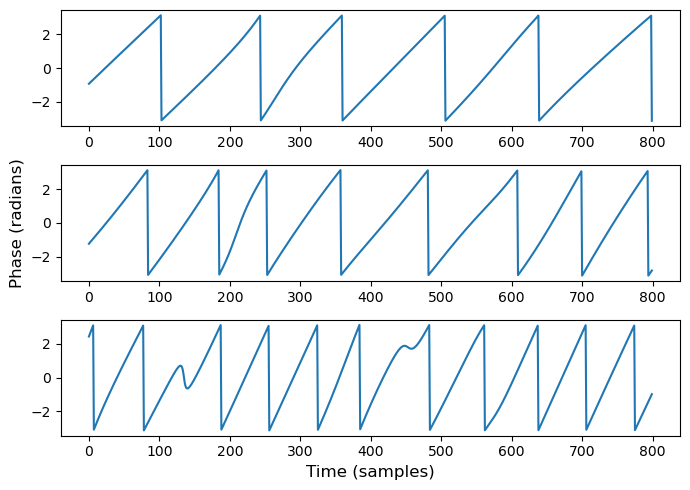

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
ax = plt.subplot(311)
plt.plot(all_phase[0, 0, 0, :])  # 3Hz, first event, first electrode.
ax = plt.subplot(312)
plt.plot(all_phase[2, 0, 0, :])  # 5Hz
plt.ylabel('Phase (radians)', fontsize=12)
ax = plt.subplot(313)
plt.plot(all_phase[4, 0, 0, :])  # 7Hz
plt.xlabel('Time (samples)', fontsize=12)
plt.tight_layout()

Phase measures vary from 0 to +2pi. Often, the wavelet transform imposes a level of consistency on the phase measure, so you'll often see phase vary smoothly around the circle. However, this is not a given -- you'll often find meaningful discontinuities or changes in the phase rate of change. 

**Note**: The discontinuities you see above are normal. The transition from -pi to +pi would be smooth if plotted on polar axes.

### Single-electrode phase-locking

Phase-locking refers to the consistency of a given phase (or phase difference) across time or across trials. For example, it is common to ask whether an oscillation exhibits phase locking to a a moment just after stimulus onset. Assessing this is relatively straightforward:

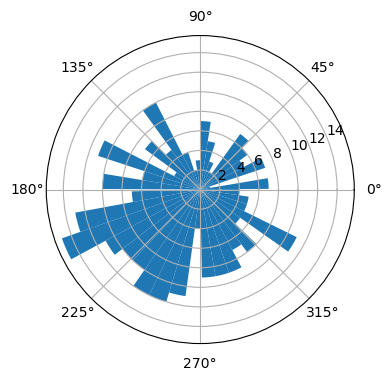

In [4]:
# Assess phase-locking to stimulus onset in electrode 0 of R1111M,
# at 5Hz, at the 150th sample, 300ms after word exposure].
phs = all_phase[2, :, 36, 150]

# Plot a polar histogram of those phases.
plt.figure(figsize=(4, 4))
ax = plt.subplot(111, polar=True)
# How to get polar histograms. (Super easy!)
plt.hist(phs, 40);

This looks pretty messy, but actually, there's decent evidence of phase locking. Many more phases are clustered in the right semicircle than the left (i.e. between 90 degrees and 270 degrees), indicating a preference for phases in that direction. We can use the **Rayleigh test** to ask whether this asymmetrical clustering is significant.

In [5]:
# We'll need the pycircstat package to help us with circular statistics.
import pycircstat as circ

circ.rayleigh?

Signature: circ.rayleigh(alpha, w=None, d=None, axis=None)
Docstring:
Computes Rayleigh test for non-uniformity of circular data.

H0: the population is uniformly distributed around the circle
HA: the populatoin is not distributed uniformly around the circle

Assumption: the distribution has maximally one mode and the data is
sampled from a von Mises distribution!

:param alpha: sample of angles in radian
:param w:       number of incidences in case of binned angle data
:param d:     spacing of bin centers for binned data, if supplied
              correction factor is used to correct for bias in
              estimation of r
:param axis:  compute along this dimension, default is None
              if axis=None, array is raveled
:return pval: two-tailed p-value
:return z:    value of the z-statistic

References: [Fisher1995]_, [Jammalamadaka2001]_, [Zar2009]_
File:      /usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/pycircstat/tests.py
Type:      fu

In [6]:
p, z = circ.rayleigh(phs)
print(p)

5.934159507547274e-07


Looks like there's significant phase-locking! (But note that we critically did not correct for multiple comparisons that were done behind the scenes to find this electrode.) Our distribution is not uniformly distributed around the circle. What would nonsignificant phase locking look like?

0.15985808172796306


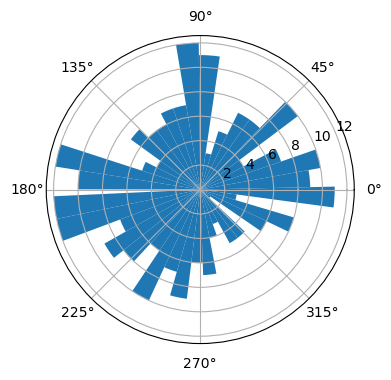

In [7]:
phs2 = all_phase[2, :, 1, 150]  # Let's try electrode 1...

# Plot a polar histogram.
plt.figure(figsize=(4, 4))
ax = plt.subplot(111, polar=True)
plt.hist(phs2, 40);

print(circ.rayleigh(phs2)[0])

No significant phase locking here. These phases are distributed uniformly around the circle.

Finally, let's ask if there's a difference between remembered and not-remembered phase locking.

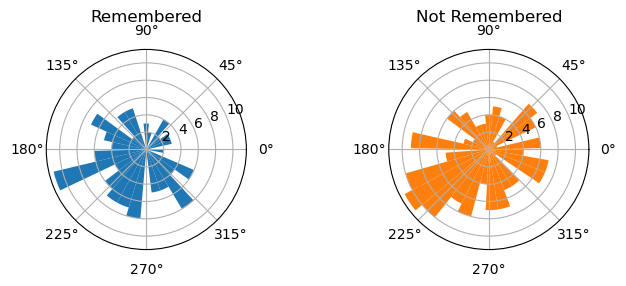

In [8]:
recalled = np.array(recalled)

phs_rec = all_phase[2, recalled==1, 36, 150]
phs_nrec = all_phase[2, recalled==0, 36, 150]

# Plot a polar histogram.
plt.figure(figsize=(7, 3))
ax = plt.subplot(121, polar=True)
plt.hist(phs_rec, 30);
plt.title('Remembered', y=1.1, fontsize=12)
ax = plt.subplot(122, polar=True)
plt.hist(phs_nrec, 30, color='C1');
plt.title('Not Remembered', y=1.1, fontsize=12)
plt.tight_layout()

There are additional tests we could run to ask if there's a significant difference in phase-locking between these two distributions, but we'll leave that to the reference material (in short, permutation tests work well here). Visually, it does not seem as if the remembered/not-remembered distributions are much different.

### Cross-electrode phase-locking (connectivity)

Computing phase-locking at a single electrode tells us whether there's a bias in the preferred phase of an oscillation, at a given time. But if we want to know whether there's correlated phases *between* two electrodes, we need to slightly modify our procedure.

#### Computing phase-locking value between electrodes
1. Extract phase timeseries from both electrodes at desired frequency.
2. Subtract phase timeseries from one another (i.e. find the phase difference).
3. Compute the **resultant vector length**, a measure of phase consistency, at an appropriate window in the difference timeseries.
4. *Optional*: Depending on your analysis design, you can also compute PLV over time, instead of over trials, by measuring the resultant vector length across samples in one timeseries.

In [9]:
# Let's try computing 5Hz connectivity between electrode 10 and 22.
elec1 = all_phase[2, :, 10, :]
elec2 = all_phase[2, :, 22, :]

# The cdiff function keeps subtracted phases within the 0 to +2pi range.
diff = circ.cdiff(elec1, elec2)

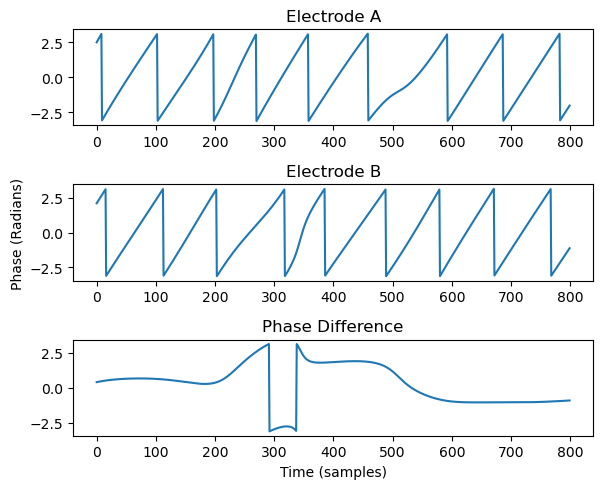

In [10]:
# Just visualize the first event.
plt.figure(figsize=(6, 5))
ax = plt.subplot(311)
plt.plot(elec1[0])
plt.title('Electrode A')
ax = plt.subplot(312)
plt.plot(elec2[0])
plt.title('Electrode B')
plt.ylabel('Phase (Radians)')
ax = plt.subplot(313)
plt.plot(diff[0])
plt.xlabel('Time (samples)')
plt.title('Phase Difference')
plt.tight_layout()

The bottom row shows the phase difference, over time, between electrodes 10 and 20. One way to assess connectivity between these electrodes would be to examine the **consistency** of this phase difference, over time. For example, is there a consistent phase difference between these two electrodes across many oscillations? Sure looks like it!

Note that the crossings from pi to -pi do not actually indicate a sharp change, but are just how the wrapped values get displayed in the plot.

T-stat: -1.8232548555880437


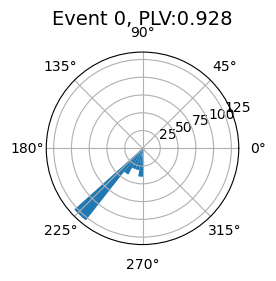

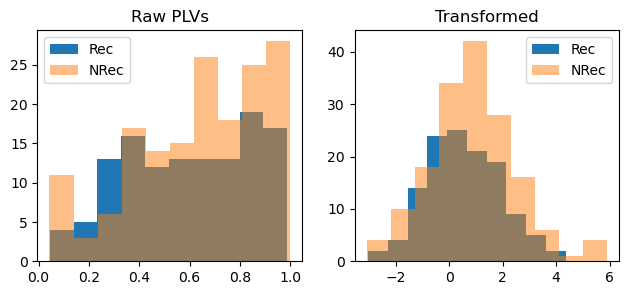

In [11]:
# Plot the distribution of phase differences between electrodes for
# event 1, from 0 to 600 ms
plt.figure(figsize=(2.5, 2.5))
ax = plt.subplot(111, polar=True)
diff_range = diff[1, 0:300]
plt.hist(diff_range, 10);
plt.title('Event 0, PLV:'+str(np.round(circ.resultant_vector_length(diff_range), 3)), y=1.1, fontsize=14)

# Compute the mean resultant vector length, which tells us the strength of phase locking
rvls = circ.resultant_vector_length(diff[:, 0:300], axis=1)

# Compare recalled vs. not-recalled phase locking

plt.figure(figsize=(7.5, 3))
ax = plt.subplot(121)
plt.hist(rvls[recalled==1], label='Rec')
plt.hist(rvls[recalled==0], alpha=0.5, label='NRec')
plt.legend()
plt.title('Raw PLVs')

from scipy.special import logit  # the logit transform will make our RVL distributions more normal
ax = plt.subplot(122)
plt.hist(logit(rvls[recalled==1]), label='Rec')
plt.hist(logit(rvls[recalled==0]), alpha=0.5, label='NRec')
plt.legend()
plt.title('Transformed')

# The t-test is not the best test for these data,
# since they're restricted to 0 to 1 and can exhibit highly non-normal distributions.
# But for the sake of a demo:
from scipy.stats import ttest_ind
t, p = ttest_ind(logit(rvls[recalled==1]), logit(rvls[recalled==0]), equal_var=False)
print('T-stat: '+str(t))

What if we do the same analysis, but ask about phase-locking over trials instead of over time?

Rem PLV:0.026270391966495974
NRem PLV:0.08097052115505603


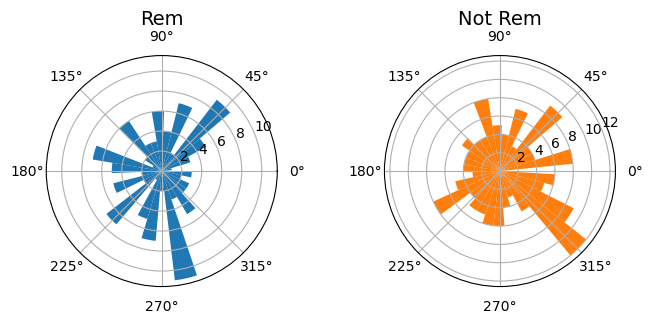

In [12]:
# Take the mean phase difference over time.
# First, average phase differences in our window of interest.
diff_avg = circ.mean(diff[:, :300], axis=1)

# Plot results.
plt.figure(figsize=(8, 3))
ax = plt.subplot(121, polar=True)
plt.hist(diff_avg[recalled==1], 30);
plt.title('Rem', y=1.1, fontsize=14)
plt.subplot(122, polar=True)
plt.hist(diff_avg[recalled==0], 30, color='C1')
plt.title('Not Rem', y=1.1, fontsize=14)

# Compute mean resultant vector length (i.e. PLV).
print('Rem PLV:'+str(circ.resultant_vector_length(diff_avg[recalled==1])))
print('NRem PLV:'+str(circ.resultant_vector_length(diff_avg[recalled==0])))

Ideally, we'd use a permutation test to establish whether the difference in phase locking is statistically significant.

## Using MNE for connectivity

MNE makes it almost trivially easy to implement connectivity analyses. However, as you'll see, that simplicity comes with a tradeoff of flexibility. 

In [17]:
from mne_connectivity import spectral_connectivity_epochs

# Get MNE format EEG (note this is coming from one session)
eeg_mne = eeg.to_mne()
sr = eeg_mne.info['sfreq']

#Compute all possible pairwise combinations of phase-locking value
con_output = spectral_connectivity_epochs(eeg_mne[:100], method='plv', sfreq=sr, mode='cwt_morlet', cwt_freqs=myfreqs, fmin=3, fmax=8, cwt_n_cycles=5)

Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 24 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 9870 connections
    using t=-1.000s..2.598s for estimation (1800 points)
    frequencies: 3.0Hz..8.0Hz (6 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: PLV
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity

In [326]:
#The output of spectral_connectivity is con, freqs, times, n_epochs, and n_tapers (for multitaper connectivity)

#Compare to the PLV we would get by computing this manually
idx1 = 50
idx2 = 46

mne_plv = np.mean(con_output[0][idx1, idx2, 2, 500:600])

elec1 = all_phase[2, :, idx2, :]
elec2 = all_phase[2, :, idx1, :]
diff = circ.cdiff(elec1, elec2)
manual_plv = np.mean( circ.resultant_vector_length(diff[300:400, 0:100], axis=0) )  #taking the last 300 events, since we only ran the MNE function on data from session 1.

print('Manual: '+str(manual_plv))
print('MNE: '+str(mne_plv))

Manual: 0.1024772737597551
MNE: 0.10192742250165271


### Adjacency Matrix

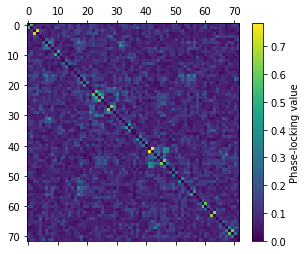

In [328]:
figure(figsize=(4.75, 4))
to_plot_plv = np.mean(adjmat_plv[:, :, 2, 500:600], 2)
to_plot_plv = np.sum([to_plot_plv, to_plot_plv.T], 0)   #symmetrize the matrix
matshow(to_plot_plv, fignum=0, aspect='auto',)
cb = colorbar(); cb.set_label('Phase-locking value')

In [329]:
## Multitaper Coherence

#Compute all possible pairwise combinations of multitaper coherence -- should be much faster than wavelets!
con_output_coh = spectral_connectivity(eeg_mne[:100], method='coh', sfreq=eeg.samplerate, mode='multitaper', fmin=3, fmax=8, faverage=True, tmin=0, tmax=0.2)

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2556 connections
    using t=0.000s..0.200s for estimation (101 points)
fmin=3.000 Hz corresponds to 0.606 < 5 cycles based on the epoch length 0.202 sec, need at least 1.667 sec epochs or fmin=24.752. Spectrum estimate will be unreliable.
    frequencies: 5.0Hz..5.0Hz (1 points)
    connectivity scores will be averaged for each band
    using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computin

<ipython-input-329-a6e04357091b>:4: RuntimeWarning: fmin=3.000 Hz corresponds to 0.606 < 5 cycles based on the epoch length 0.202 sec, need at least 1.667 sec epochs or fmin=24.752. Spectrum estimate will be unreliable.
  con_output_coh = spectral_connectivity(eeg_mne[:100], method='coh', sfreq=eeg.samplerate, mode='multitaper', fmin=3, fmax=8, faverage=True, tmin=0, tmax=0.2)


    computing connectivity for epoch 60
    computing connectivity for epoch 61
    computing connectivity for epoch 62
    computing connectivity for epoch 63
    computing connectivity for epoch 64
    computing connectivity for epoch 65
    computing connectivity for epoch 66
    computing connectivity for epoch 67
    computing connectivity for epoch 68
    computing connectivity for epoch 69
    computing connectivity for epoch 70
    computing connectivity for epoch 71
    computing connectivity for epoch 72
    computing connectivity for epoch 73
    computing connectivity for epoch 74
    computing connectivity for epoch 75
    computing connectivity for epoch 76
    computing connectivity for epoch 77
    computing connectivity for epoch 78
    computing connectivity for epoch 79
    computing connectivity for epoch 80
    computing connectivity for epoch 81
    computing connectivity for epoch 82
    computing connectivity for epoch 83
    computing connectivity for epoch 84


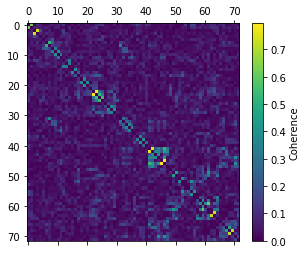

In [330]:
figure(figsize=(4.75, 4))
to_plot_coh = con_output_coh[0][:, :, 0]
to_plot_coh = np.sum([to_plot_coh, to_plot_coh.T], 0)   #symmetrize the matrix
matshow(to_plot_coh, fignum=0, aspect='auto',)
cb = colorbar(); cb.set_label('Coherence')

Text(0,0.5,'Coherence')

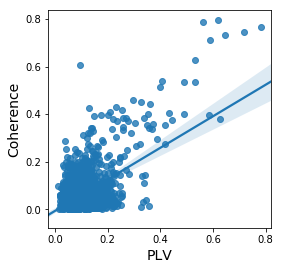

In [335]:
#Directly compare both methods

A = to_plot_plv[np.tril_indices_from(to_plot_plv, -1)]
B = to_plot_coh[np.tril_indices_from(to_plot_coh, -1)]

import seaborn as sns

figure(figsize=(4, 4)); ax=subplot(111)
sns.regplot(A, B)
xlabel('PLV', fontsize=14); ylabel('Coherence', fontsize=14)

**Exercise: Compute the number of electrodes with significant phase locking in the gamma band (let's use 80Hz), using the same 0ms to 1600ms word encoding time window as above**

**Exercise: Write a function to compute phase locking for all possible pairs of electrodes in this subject, at a given frequency and time range. Use this with plt.matshow to make a 2D plot of the phase locking (with electrodes on both axes).**